In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#To use double-precision numbers: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from patch_gnn.splitting import train_test_split
from jax import random, vmap, nn
from patch_gnn.seqops import one_hot
from patch_gnn.graph import graph_tensors,stack_feature_tensors
from patch_gnn.layers import softmax_on_non_zero,concatenate_node_features,get_norm_attn_matrix
from patch_gnn.models import MPNN, DeepMPNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position
import jax.numpy as jnp
import numpy as np

pd.set_option('display.max_rows', 100)
from jax.config import config 
config.update("jax_debug_nans", True)

#### The goal for this notebook is to test if using (n_node, n_feat) matrix rather than adjacency matrix + feature matrix could give any results

In [4]:
data = load_ghesquire()

graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"
processed_data_path = here() / "data/ghesquire_2011/processed_data.pkl"

with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

# the cleaned data has everything processed and ready to be used for deep learning
with open(processed_data_path, "rb") as f:
    processed_data = pkl.load(f)
    
key = random.PRNGKey(490)

In [5]:
# select the graphs that only exist in fitered dataset
# one cannot directly loop through the dict keys, and delete certain ones b/c it is changing 
graphs_to_remove = []
for graph_key in graphs.keys():
    if graph_key not in processed_data["accession-sequence"].tolist():
        print(graph_key)
        graphs_to_remove.append(graph_key)
for graph_key in graphs_to_remove:
    graphs.pop(graph_key)
print(f"the filtered graphs has {len(list(graphs.values()))} graphs")

Q8IXH7-MFTSMDPPPVELIR
P00492-VFIPHGLIMDR
O75874-LIDDMVAQAMK
P67936-MEIQEMQLK
the filtered graphs has 359 graphs


### Convert inputs to (n_graph, max_num_node, num_features)
forget about sasa and fluc features for a sec

In [6]:
train_df, test_df = train_test_split(key, processed_data)
len(train_df), len(test_df)

(251, 108)

In [7]:
train_graph = graph_tensors(train_df, graphs)
test_graph = graph_tensors(test_df, graphs)
train_target = train_df['ox_fwd_logit'].values
test_target = test_df['ox_fwd_logit'].values

In [8]:
adj_matrix, feature_matrix = train_graph
adj_matrix.shape, feature_matrix.shape

((251, 20, 20, 1), (251, 20, 67))

#### GAT

In [9]:
from functools import partial
import seaborn as sns
from patch_gnn.models import DeepGAT
from patch_gnn.layers import concatenate_node_features, node_attention

In [10]:
model = DeepGAT(node_feature_shape=(20, 67), num_adjacency=1, num_training_steps=5000)
attentions, output = vmap(partial(node_attention, model.params[0]))(train_graph)

In [11]:
model.params[0][0]

DeviceArray([[-0.02560492, -0.00924249, -0.0045675 , ...,  0.00373779,
              -0.00339509,  0.01489962],
             [ 0.00414905,  0.01542737, -0.01743275, ...,  0.00212588,
               0.00288546,  0.00363956],
             [ 0.00732468, -0.00153784, -0.01622383, ..., -0.00479539,
               0.00045189,  0.00337567],
             ...,
             [-0.00760192, -0.00677182,  0.01236274, ..., -0.00971496,
               0.00479079, -0.00768552],
             [-0.02179639,  0.01401106, -0.00445629, ...,  0.01537564,
               0.00787088,  0.00836402],
             [ 0.0008844 ,  0.00592836, -0.00128998, ...,  0.00443935,
              -0.00514845, -0.00535213]], dtype=float64)

Take a look at node attention before training

<AxesSubplot:>

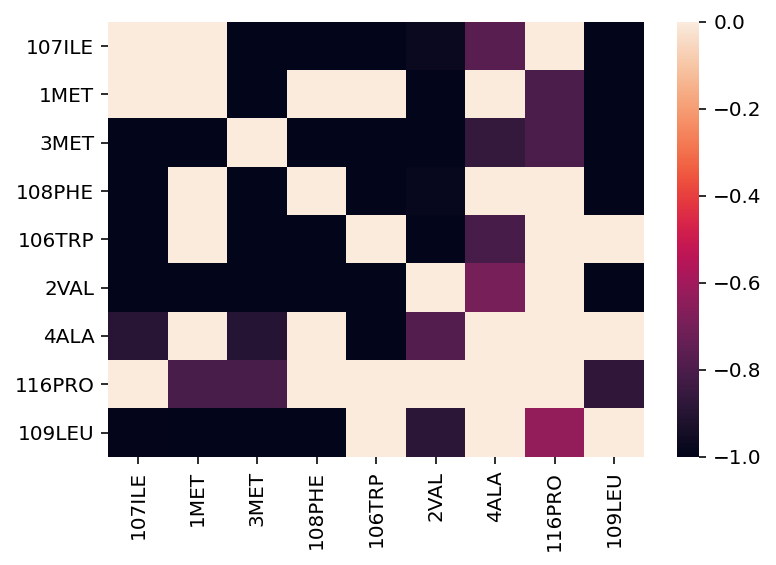

In [12]:
labels = list(graphs[train_df["accession-sequence"].tolist()[1]].nodes())
sns.heatmap(attentions[1, :len(labels), :len(labels)], xticklabels = labels, yticklabels= labels)

train model

In [14]:
model.fit(train_graph, train_target)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [16]:
model.params[0][0]

DeviceArray([[-0.02677356, -0.00949929, -0.00459459, ...,  0.00377472,
              -0.00313778,  0.01481487],
             [ 0.00283899,  0.01513463, -0.01735751, ...,  0.00231611,
               0.00314315,  0.00357616],
             [ 0.00456509, -0.00248521, -0.01622147, ..., -0.00460627,
               0.00095323,  0.00326079],
             ...,
             [-0.01132415, -0.00794116,  0.01237822, ..., -0.00955379,
               0.00549968, -0.00794959],
             [-0.03411884,  0.00661387, -0.00303516, ...,  0.01953342,
               0.00821075,  0.00453427],
             [ 0.01765647,  0.01616336, -0.00031143, ...,  0.00517127,
              -0.01363394, -0.00442324]], dtype=float64)

In [17]:
checkpoint = -1
preds = model.predict(test_graph, checkpoint=checkpoint)
train_preds = model.predict(train_graph, checkpoint=checkpoint)

Text(0.5, 1.0, 'Test target vs. test pred')

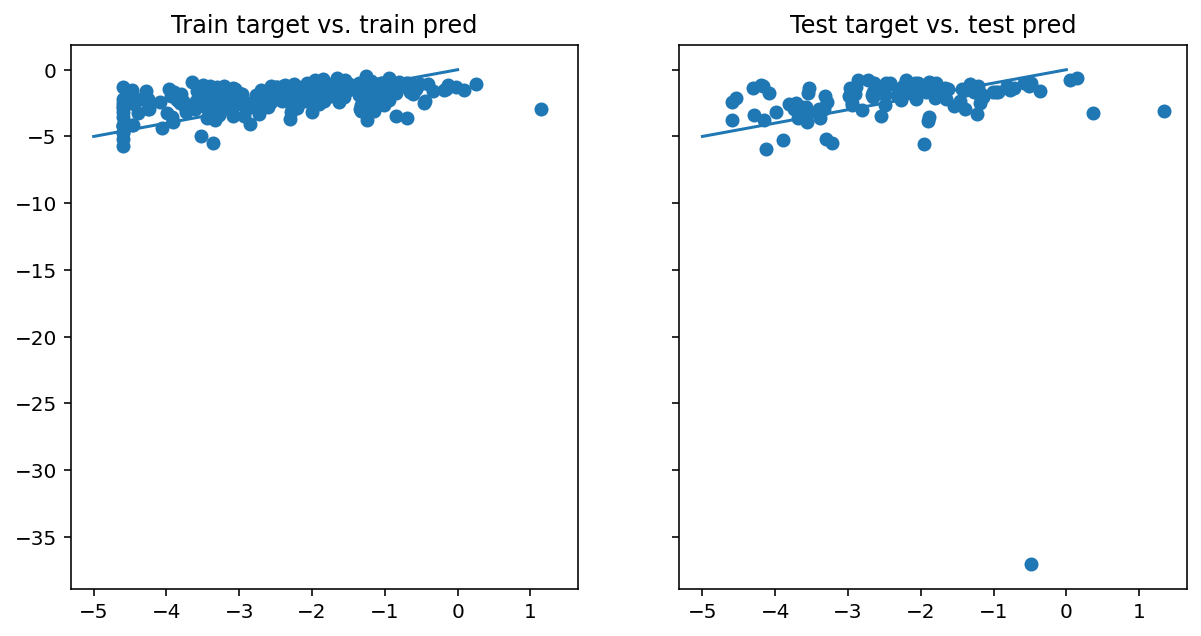

In [18]:
fig, ax = plt.subplots(
        figsize=(10, 5), nrows=1, ncols=2, sharex=True, sharey=True,
    )
ax[0].scatter(train_target.squeeze(), train_preds.squeeze())
ax[0].plot([-5, 0], [-5, 0])
ax[0].set_title("Train target vs. train pred")
ax[1].scatter(test_target.squeeze(), preds.squeeze())
ax[1].plot([-5, 0], [-5, 0])
ax[1].set_title("Test target vs. test pred")

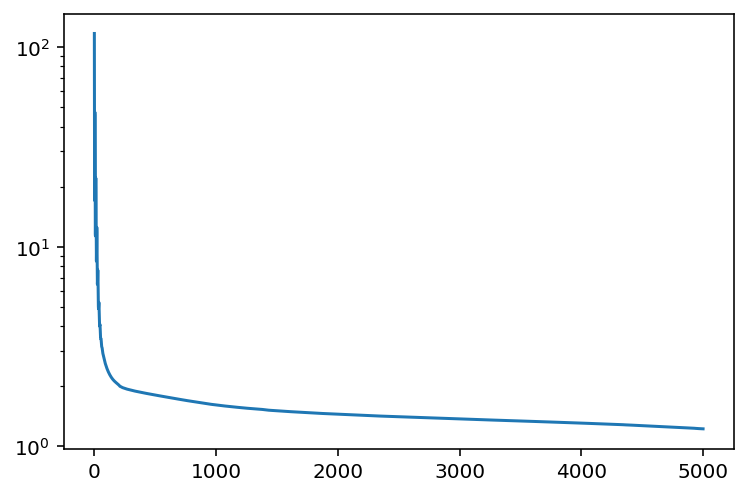

In [20]:
plt.plot(model.loss_history)
plt.yscale("log")

In [21]:
from tqdm.auto import tqdm
from sklearn.metrics import explained_variance_score as evs, r2_score as r2
from jax import jit
def learning_curves(model, data, score_func, *, interval: int=20):
    X, y = data
    scores = []
    for i in tqdm(range(len(model.loss_history))[::interval]):
        preds = model.predict(X, checkpoint=i)
        score = score_func(y.squeeze(), preds.squeeze())
        scores.append(score)
    return scores

In [22]:
interval = 1
train_score = learning_curves(model, (train_graph, train_target), r2, interval=interval)
test_score = learning_curves(model, (test_graph, test_target), r2, interval=interval)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'r2')

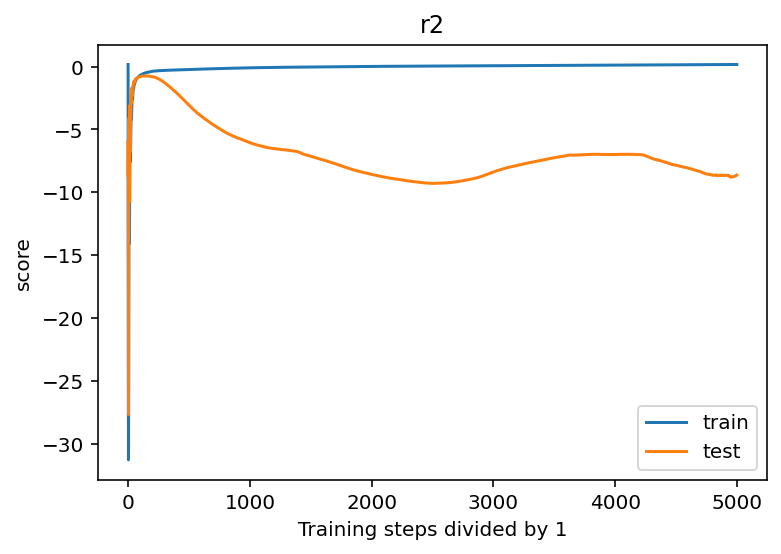

In [23]:
plt.plot(train_score, label="train")
plt.plot(test_score, label="test")
plt.legend()
plt.xlabel(f"Training steps divided by {interval}")
plt.ylabel("score")
plt.title("r2")

In [25]:
r2(train_target.squeeze(), train_preds.squeeze()), evs(train_target.squeeze(), train_preds.squeeze())

(0.1640258534955915, 0.19050239285786863)

### Explore what’s learned by GATs

(251, 20, 20)

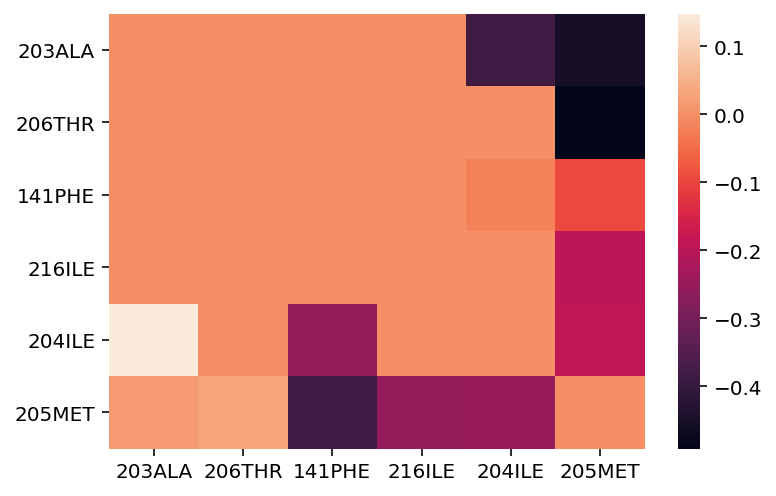

In [26]:
attentions, output = vmap(partial(node_attention, model.params[0]))(train_graph)
#ax = sns.heatmap(attentions[idx][0:len(g.nodes()), 0:len(g.nodes())], cmap="viridis")
#ax.set_xticklabels(list(g.nodes()), rotation = 90)
#ax.set_yticklabels(list(g.nodes()), rotation = 0)
labels = list(graphs[train_df["accession-sequence"].tolist()[0]].nodes())
sns.heatmap(attentions[0, :len(labels), :len(labels)], xticklabels = labels, yticklabels= labels)
attentions.shape

In [27]:
attentions[0, :len(labels), :len(labels)]

DeviceArray([[-0.        , -0.        , -0.        , -0.        ,
              -0.38115023, -0.45500479],
             [-0.        , -0.        , -0.        , -0.        ,
              -0.        , -0.49149899],
             [ 0.        ,  0.        , -0.        , -0.        ,
              -0.02120609, -0.09506065],
             [ 0.        ,  0.        , -0.        , -0.        ,
              -0.        , -0.19460422],
             [ 0.14796837,  0.        , -0.25228489, -0.        ,
              -0.        , -0.18927072],
             [ 0.0161095 ,  0.03146893, -0.38414377, -0.25258481,
              -0.24727503, -0.        ]], dtype=float64)

The vertical numbers are not all identical. Keep that in mind.

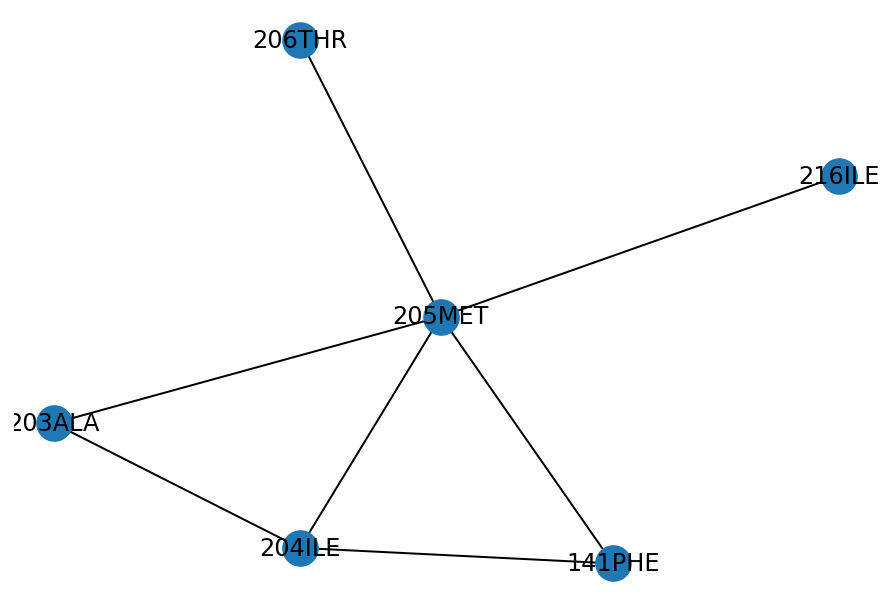

In [28]:
import networkx as nx
nx.draw(graphs[train_df["accession-sequence"].tolist()[0]], with_labels=True)

# GRAVEYARD

In [ ]:
from patch_gnn.layers import normalize_if_nonzero
from jax import grad

In [ ]:
normalize_if_nonzero(p_vect=np.zeros(3))

In [ ]:
a = np.array([0.1, 0.5, 0.0])
normalize_if_nonzero(p_vect=a)

In [ ]:
def f(p):
    p = normalize_if_nonzero(p)
    return np.sum(p)

In [ ]:
f(np.)

In [ ]:
df = grad(f)

In [ ]:
df(np.zeros(3)),  df(a)